### INSTALACION DE LOS PAQUETES NECESARIOS

In [1]:
! pip install -U spacy
! python -m spacy download en
! pip install spacy
! pip install spacymoji
! pip install emoji
! pip install scikit-learn
! pip install gensim
! pip install sklearn
! pip install matplotlib
! pip install transformers
! pip install torch


[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 12.8/12.8 MB 4.0 MB/s eta 0:00:00
[!] As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use
the full pipeline package name 'en_core_web_sm' instead.
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 7.7/7.7 MB 4.6 MB/s eta 0:00:00
     -------------------------------------- 269.6/269.6 kB 4.1 MB/s eta 0:00:00
     ---------------------------------------- 2.2/2.2 MB 4.0 MB/s eta 0:00:00
     -------------------------------------- 302.0/302.0 kB 6.3 MB/s eta 0:00:00
     -------------------------------------- 277.4/277.4 kB 4.2 MB/s eta 0:00:00
     -------------------------------------- 166.4/166.4 kB 4.9 MB/s eta 0:00:00
     -------------------------------------- 295.0/295.0 kB 2.6 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


     -------------------------------------- 192.3/192.3 MB 4.5 MB/s eta 0:00:00
     ---------------------------------------- 1.6/1.6 MB 5.5 MB/s eta 0:00:00
     ---------------------------------------- 5.7/5.7 MB 5.4 MB/s eta 0:00:00
     -------------------------------------- 536.2/536.2 kB 5.6 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import spacy
import transformers
import torch
import emoji
import numpy as np
from tqdm import tqdm

from sklearn.cluster import DBSCAN
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.test.utils import get_tmpfile

# 1. Preparación del Dataset

## 1.1. CARGAR FICHERO CSV CON LOS DATOS

In [13]:
datsetPath = '../Datasets/corto.csv'
#datsetPath = '../Datasets/SuicideDetection.csv'

data = pd.read_csv(datsetPath)

data.info()
data.head(n=5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  76 non-null     int64 
 1   text        76 non-null     object
 2   class       76 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.9+ KB


,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


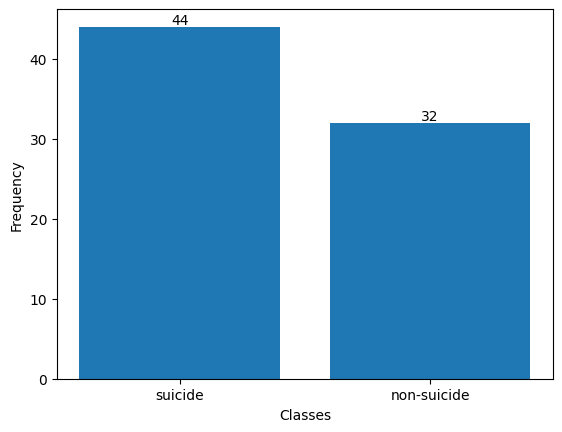

In [14]:
from matplotlib import pyplot as plt

barPlot = plt.bar(data['class'].value_counts().index, data['class'].value_counts())
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.bar_label(barPlot)
plt.show()

## 1.2. SELECCIONAR LA COLUMNA DE TEXTOS (DISCRIMINAR LA CLASE)

In [15]:
textos = []
for instancia in data.values:
    textos.append(instancia[1])

# 2. Pre-proceso
## 2.1. LIMPIEZA Y FORMARTEO DE LOS DATOS

In [16]:
# Cuidado! La ejecución de este bloque con 232074 instancias, toma aproximademente 5 min? 

nlp = spacy.load("en_core_web_sm") # Cargar modelo
nlp.add_pipe("emoji", first=True)

textos_tokenizados = []
for texto in tqdm(textos, desc="Procesando textos"):
    texto = emoji.demojize(texto)  # Emojis a texto
    doc = nlp(texto)
    lexical_tokens = [token.lemma_.lower() for token in doc if len(token.text) > 3 and token.is_alpha]
    textos_tokenizados.append(lexical_tokens)

Procesando textos: 100%|██████████| 76/76 [00:01<00:00, 45.22it/s]


In [17]:
print(textos[0])
print(textos_tokenizados[0])

Ex Wife Threatening SuicideRecently I left my wife for good because she has cheated on me twice and lied to me so much that I have decided to refuse to go back to her. As of a few days ago, she began threatening suicide. I have tirelessly spent these paat few days talking her out of it and she keeps hesitating because she wants to believe I'll come back. I know a lot of people will threaten this in order to get their way, but what happens if she really does? What do I do and how am I supposed to handle her death on my hands? I still love my wife but I cannot deal with getting cheated on again and constantly feeling insecure. I'm worried today may be the day she does it and I hope so much it doesn't happen.
['wife', 'threaten', 'suiciderecently', 'leave', 'wife', 'good', 'because', 'cheat', 'twice', 'lie', 'much', 'that', 'have', 'decide', 'refuse', 'back', 'day', 'begin', 'threaten', 'suicide', 'have', 'tirelessly', 'spend', 'these', 'paat', 'day', 'talk', 'keep', 'hesitate', 'because'

In [ ]:
import torch
import transformers
import spacy

# Cargar el modelo BERT pre-entrenado
model_name = "bert-base-uncased"  # Puedes usar otro modelo según tus necesidades
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModel.from_pretrained(model_name)

# Definir un array de strings que deseas vectorizar


# Inicializar un vector donde almacenarás las representaciones de cada texto
representaciones = []

# Procesar cada texto y obtener su representación
for texto in textos:
    # Tokenizar el texto
    tokens = tokenizer(texto, return_tensors="pt")

    # Obtener la representación oculta (embedding) del texto
    with torch.no_grad():
        output = model(**tokens)

    # El vector de representación del texto se encuentra en output.last_hidden_state
    vector = output.last_hidden_state.mean(dim=1)  # Puedes usar diferentes estrategias de agregación según tu caso
    representaciones.append(vector)

## 2.2. Espacio de decisión - VECTORIZACION DE LOS DATOS (DOC2VEC)

In [18]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(textos_tokenizados)]
model = Doc2Vec(documents, vector_size=150, window=2, dm=1, epochs=100, workers=4)
# DM siempre a 1 para que sea distributed memory (que tenga en cuenta el contexto)
# Window se puede cambiar pero tener en cuenta que cuanto mayor sea mas coste genera
# Negative: siempre a 0 para que aprenda que palabras son ruido
#Los que se pueden probar para parametro ekorketa:
    # VECTOR SIZE!!!! (tamaño del embedding: dimensiones)
    # Epochs: numero de iteraciones por el dataset
    # Alpha: learning rate inicial
    # Min alpha: El valor de LR con el que va acabar → Igual no poner?
    # Max_vocab_size: Limita el tamaño maximo de las palabras a tener en cuenta (borra las menos frecuentes)

model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

model.save(get_tmpfile("my_doc2vec_model"))

#vector = model.infer_vector(['wife', 'threaten', 'leave', 'wife', 'good', 'because', 'cheat', 'twice', 'lie', 'much', 'that', 'have', 'decide', 'refuse', 'back', 'day', 'begin', 'threaten', 'suicide', 'have', 'tirelessly', 'spend', 'these', 'paat', 'day', 'talk', 'keep'])

#similar_documents = model.dv.most_similar(vector) # Deberia salir 0 porque es el documento del que se han sacado todas las palabras

# 3. Clustering

## 3.1. Aplicando algoritmo DBSCAN (PREDETERMINADO) de la libería sklearn

In [19]:
document_vectors = [model.infer_vector(doc) for doc in textos_tokenizados]

# Aplicar DBSCAN a los vectores de documentos
dbscan = DBSCAN(eps=2, min_samples=2, leaf_size=5)  # Ajusta los parámetros según tu caso
labels = dbscan.fit_predict(np.array(document_vectors))

# Los resultados del clustering están en 'labels'
print("Etiquetas de clusters:", labels)

Etiquetas de clusters: [-1 -1 -1  0 -1 -1 -1  0 -1 -1 -1 -1 -1 -1  0 -1 -1 -1  0 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1
 -1  1 -1 -1 -1  0 -1 -1  1 -1  0 -1  0 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1
 -1 -1  0 -1]
